In [38]:
import math
import random

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg
from matplotlib.patches import Rectangle, Circle, Polygon
import numpy as np
import torch
from sklearn.preprocessing import OneHotEncoder

device = "cuda:7"

random.seed(42)

def square_patch(center: tuple[int, int], radius: int, color: str = 'black') -> Rectangle:
    x, y = center
    return Rectangle(
        (x - radius, y - radius), 2 * radius, 2 * radius, edgecolor='black', 
        facecolor=color
    )

def circle_patch(center: tuple[int, int], radius: int, color: str = 'black') -> Circle:
    x, y = center
    return Circle(
        (x, y), radius, edgecolor='black', facecolor=color
    )

def triangle_patch(center: tuple[int, int], radius: int, color: str = 'black') -> Polygon:
    x, y = center
    sqrt3half = math.sqrt(3) / 2
    return Polygon(
        [(x, y + radius), 
         (x - sqrt3half * radius, y - radius / 2), 
         (x + sqrt3half * radius, y - radius / 2)
        ], 
        edgecolor='black', facecolor=color
    )

def square_rotated_patch(center: tuple[int, int], radius: int, color: str = 'black') -> Polygon:
    x, y = center
    return Polygon(
        [(x - radius, y), 
         (x         , y + radius), 
         (x + radius, y), 
         (x         , y - radius)
        ], 
        edgecolor='black', facecolor=color
    )

def star_patch(center: tuple[int, int], radius: int, color: str = 'black') -> Polygon:
    # Parameters
    outer_radius = radius  # Radius of outer points
    inner_radius = radius / 2  # Radius of inner points
    num_points = 5  # Number of points in the star

    # Calculate coordinates
    points = []
    angle = 2 * math.pi / num_points
    for i in range(num_points):
        # Outer point
        outer_x = center[0] + outer_radius * math.cos(i * angle)
        outer_y = center[1] + outer_radius * math.sin(i * angle)
        points.append((outer_x, outer_y))
        
        # Inner point
        inner_x = center[0] + inner_radius * math.cos(i * angle + angle / 2)
        inner_y = center[1] + inner_radius * math.sin(i * angle + angle / 2)
        points.append((inner_x, inner_y))

    return Polygon(points, edgecolor='black', facecolor=color)

patches = [
    square_patch, circle_patch, triangle_patch, square_rotated_patch
]

In [31]:
colors = ['red', 'blue', 'green', 'yellow', 'black']

def sample_patches(patches, num_samples=10):
    features, images = [], []
    sampled_indexes = random.choices(range(len(patches)), k=num_samples)
    for i in range(num_samples):
        # sampling
        sampled_patch = patches[sampled_indexes[i]]
        center = (random.uniform(0.2, 0.8), random.uniform(0.2, 0.8))
        radius = random.uniform(0.1, 0.2)
        color = random.choice(['red', 'blue', 'green', 'yellow', 'black'])
        # color = colors[sampled_indexes[i]]

        fig, ax = plt.subplots(figsize=(2, 2), dpi=64)
        # A canvas must be manually attached to the figure (pyplot would automatically
        # do it).  This is done by instantiating the canvas with the figure as
        # argument.
        canvas = FigureCanvasAgg(fig)

        # your plotting here
        patch = sampled_patch(center, radius, color)
        ax.add_patch(patch)
        plt.axis('off')

        canvas.draw()
        s, (width, height) = canvas.print_to_buffer()

        X = np.fromstring(s, np.uint8).reshape((height, width, 4))
        # drop the alpha channel
        X = X[:, :, :3]
        
        features.append((sampled_patch.__name__, color))
        images.append(X)

    return features, images

def compute_similarities(features, sim_fn):
    similarity = np.zeros((len(features), len(features)))
    for i in range(len(features)):
        for j in range(len(features)):
            similarity[i, j] = sim_fn(features[i], features[j])
    return similarity

In [39]:
%%capture
def weighted_sim(shape_coef, color_coef):
    def sim_fn(f1, f2):
        return (shape_coef * (f1[0] == f2[0]) + color_coef * (f1[1] == f2[1])) / (shape_coef + color_coef)
    return sim_fn

features, images = sample_patches(patches, 1000)
targets_shape = compute_similarities(features, weighted_sim(shape_coef=0.9, color_coef=0.1))
targets_color = compute_similarities(features, weighted_sim(shape_coef=0.1, color_coef=0.9))
obs_features = [(p + " " + c, ) for p, c in features]

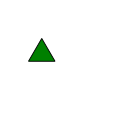

In [40]:
Image.fromarray(images[0])

Epoch 0, loss: 1.4909448623657227
Epoch 1, loss: 1.4907457828521729
Epoch 2, loss: 1.4903478622436523
Epoch 3, loss: 1.4888570308685303
Epoch 4, loss: 1.4878733158111572
Epoch 5, loss: 1.4847050905227661
Epoch 6, loss: 1.4752466678619385
Epoch 7, loss: 1.4741438627243042
Epoch 8, loss: 1.4258884191513062
Epoch 9, loss: 1.4754903316497803
Epoch 10, loss: 1.4605889320373535
Epoch 11, loss: 1.434866189956665
Epoch 12, loss: 1.3879971504211426
Epoch 13, loss: 1.4573733806610107
Epoch 14, loss: 1.438825249671936
Epoch 15, loss: 1.3882360458374023
Epoch 16, loss: 1.40326988697052
Epoch 17, loss: 1.3807239532470703
Epoch 18, loss: 1.3671886920928955
Epoch 19, loss: 1.3807127475738525
Epoch 20, loss: 1.3426765203475952
Epoch 21, loss: 1.327323079109192
Epoch 22, loss: 1.3058199882507324
Epoch 23, loss: 1.3027757406234741
Epoch 24, loss: 1.2771731615066528
Epoch 25, loss: 1.2682377099990845
Epoch 26, loss: 1.2676756381988525
Epoch 27, loss: 1.247843861579895
Epoch 28, loss: 1.2404189109802246
E

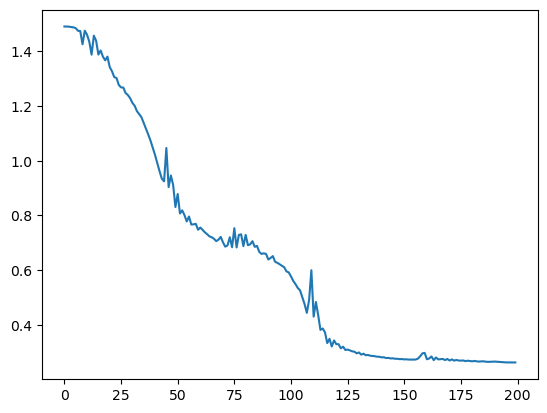

In [41]:
class SimpleCNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # 128x128
        self.conv1 = torch.nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.act1 = torch.nn.ReLU()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # 64x64
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.act2 = torch.nn.ReLU()
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # 32x32
        self.conv3 = torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.act3 = torch.nn.ReLU()
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # 16x16
        self.avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))
        self.fc = torch.nn.Linear(64, 32)
    
    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.pool3(self.act3(self.conv3(x)))
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
def train_representation(
    images: torch.Tensor,
    targets: torch.Tensor,
    temp_student=0.4,
    temp_teacher=0.1,
    num_epochs=200,
    device=device,
):
    images = images.to(device)
    targets = targets.to(device)
    model = SimpleCNN().to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=0.002)
    loss = torch.nn.KLDivLoss(reduction='batchmean')

    targets = torch.nn.functional.softmax(targets / temp_teacher, dim=1)

    logs = []

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        representations = model(images)
        representations = representations / torch.norm(representations, dim=1, keepdim=True)
        similarities = torch.matmul(representations, representations.T)
        probs = torch.nn.functional.log_softmax(similarities / temp_student, dim=1)
        loss_val = loss(probs, targets)
        loss_val.backward()
        optimizer.step()
        print(f'Epoch {epoch}, loss: {loss_val.item()}')
        logs.append({'epoch': epoch, 'loss': loss_val.item()})

    return model, logs

inputs = torch.tensor(np.array(images) / 255.0).permute(0, 3, 1, 2).float()
model_shape, logs_shape = train_representation(
    images=inputs,
    targets=torch.tensor(targets_shape).float(),
)
plt.plot([log['loss'] for log in logs_shape])

Epoch 0, loss: 1.7208746671676636
Epoch 1, loss: 1.7203433513641357
Epoch 2, loss: 1.7182387113571167
Epoch 3, loss: 1.7181882858276367
Epoch 4, loss: 1.7065216302871704
Epoch 5, loss: 1.6923482418060303
Epoch 6, loss: 1.6936695575714111
Epoch 7, loss: 1.6069833040237427
Epoch 8, loss: 1.7162915468215942
Epoch 9, loss: 1.7188163995742798
Epoch 10, loss: 1.718998908996582
Epoch 11, loss: 1.7187939882278442
Epoch 12, loss: 1.718290090560913
Epoch 13, loss: 1.7175120115280151
Epoch 14, loss: 1.7160347700119019
Epoch 15, loss: 1.713486909866333
Epoch 16, loss: 1.7088145017623901
Epoch 17, loss: 1.698754906654358
Epoch 18, loss: 1.6761232614517212
Epoch 19, loss: 1.624516487121582
Epoch 20, loss: 1.5436931848526
Epoch 21, loss: 1.4485127925872803
Epoch 22, loss: 1.3473151922225952
Epoch 23, loss: 1.2661304473876953
Epoch 24, loss: 1.1983648538589478
Epoch 25, loss: 1.3097649812698364
Epoch 26, loss: 1.1087292432785034
Epoch 27, loss: 1.1205906867980957
Epoch 28, loss: 1.1106699705123901
Epo

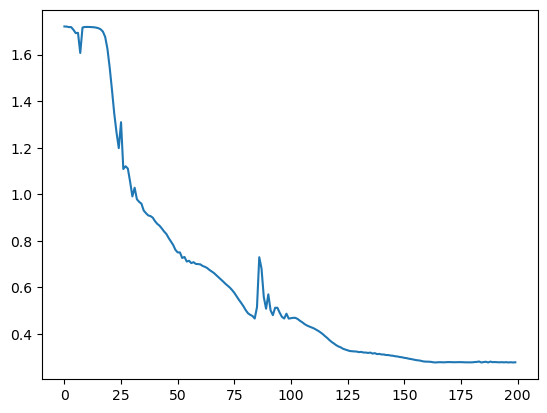

In [42]:
model_color, logs_color = train_representation(
    images=inputs,
    targets=torch.tensor(targets_color).float(),
)
plt.plot([log['loss'] for log in logs_color])

In [5]:
torch.nn.functional.softmax(torch.tensor(targets_shape) / 0.1, dim=1).round(decimals=4)

tensor([[0.0079, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0087, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0080,  ..., 0.0029, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0031,  ..., 0.0084, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0080, 0.0030],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0029, 0.0078]],
       dtype=torch.float64)

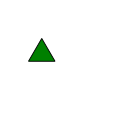

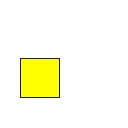

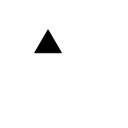

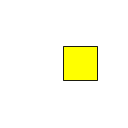

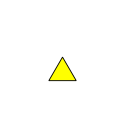

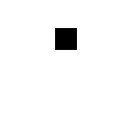

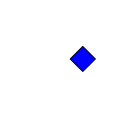

In [103]:
from IPython.display import display
indices = [0, 1, 4, 10, 11, 12, 6]
images_of_interest = [Image.fromarray(images[i]) for i in indices]
display(*images_of_interest)

In [44]:
reps_shape = model_shape(inputs[indices].to(device))
reps_shape = reps_shape / torch.norm(reps_shape, dim=1, keepdim=True)
print("Similarity matrix for shape:")
print(torch.softmax(reps_shape @ reps_shape.T / 0.4, dim=1).round(decimals=3))
reps_color = model_color(inputs[indices].to(device))
reps_color = reps_color / torch.norm(reps_color, dim=1, keepdim=True)
print("Similarity matrix for color:")
print(torch.softmax(reps_color @ reps_color.T / 0.4, dim=1).round(decimals=3))

Similarity matrix for shape:
tensor([[0.3180, 0.0180, 0.3000, 0.0220, 0.2770, 0.0290, 0.0350],
        [0.0190, 0.3210, 0.0180, 0.3180, 0.0210, 0.3020, 0.0020],
        [0.3000, 0.0170, 0.3180, 0.0210, 0.2780, 0.0280, 0.0380],
        [0.0220, 0.3120, 0.0200, 0.3150, 0.0240, 0.3040, 0.0020],
        [0.2830, 0.0210, 0.2850, 0.0250, 0.3250, 0.0300, 0.0310],
        [0.0280, 0.2960, 0.0270, 0.3030, 0.0290, 0.3140, 0.0020],
        [0.0820, 0.0050, 0.0890, 0.0050, 0.0700, 0.0060, 0.7420]],
       device='cuda:7', grad_fn=<RoundBackward1>)
Similarity matrix for color:
tensor([[0.8010, 0.0260, 0.0330, 0.0270, 0.0360, 0.0420, 0.0360],
        [0.0100, 0.3170, 0.0160, 0.3170, 0.3080, 0.0160, 0.0160],
        [0.0190, 0.0230, 0.4520, 0.0220, 0.0180, 0.4420, 0.0230],
        [0.0100, 0.3170, 0.0160, 0.3170, 0.3090, 0.0160, 0.0150],
        [0.0150, 0.3110, 0.0130, 0.3130, 0.3200, 0.0140, 0.0150],
        [0.0230, 0.0230, 0.4420, 0.0230, 0.0190, 0.4510, 0.0180],
        [0.0350, 0.0390, 0.0400, 

In [45]:
shape_embeddings = model_shape(inputs.to(device)).detach()
shape_embeddings = shape_embeddings / torch.norm(shape_embeddings, dim=1, keepdim=True)
color_embeddings = model_color(inputs.to(device)).detach()
color_embeddings = color_embeddings / torch.norm(color_embeddings, dim=1, keepdim=True)

In [100]:
point_of_explain = "square_patch yellow"
feature_encoder = OneHotEncoder(sparse_output=False, drop=[point_of_explain]).fit(obs_features)
numeric_features = feature_encoder.transform(obs_features)
feature_encoder.categories_, numeric_features.shape

([array(['circle_patch black', 'circle_patch blue', 'circle_patch green',
         'circle_patch red', 'circle_patch yellow', 'square_patch black',
         'square_patch blue', 'square_patch green', 'square_patch red',
         'square_patch yellow', 'square_rotated_patch black',
         'square_rotated_patch blue', 'square_rotated_patch green',
         'square_rotated_patch red', 'square_rotated_patch yellow',
         'triangle_patch black', 'triangle_patch blue',
         'triangle_patch green', 'triangle_patch red',
         'triangle_patch yellow'], dtype=object)],
 (1000, 19))

2025-01-22 10:58:40 - INFO - Epoch  0, Step    0, Loss: 1.01451
2025-01-22 10:58:40 - INFO - Epoch  1, Step    0, Loss: 1.01452
2025-01-22 10:58:40 - INFO - Epoch  2, Step    0, Loss: 1.01454
2025-01-22 10:58:40 - INFO - Epoch  3, Step    0, Loss: 1.01457
2025-01-22 10:58:40 - INFO - Epoch  4, Step    0, Loss: 1.01459


2025-01-22 10:58:40 - INFO - Epoch  5, Step    0, Loss: 1.01463
2025-01-22 10:58:40 - INFO - Epoch  6, Step    0, Loss: 1.01466
2025-01-22 10:58:40 - INFO - Epoch  7, Step    0, Loss: 1.01470
2025-01-22 10:58:40 - INFO - Epoch  8, Step    0, Loss: 1.01474
2025-01-22 10:58:40 - INFO - Epoch  9, Step    0, Loss: 1.01478
2025-01-22 10:58:40 - INFO - Epoch 10, Step    0, Loss: 1.01483
2025-01-22 10:58:40 - INFO - Epoch 11, Step    0, Loss: 1.01488
2025-01-22 10:58:40 - INFO - Epoch 12, Step    0, Loss: 1.01493
2025-01-22 10:58:40 - INFO - Epoch 13, Step    0, Loss: 1.01498
2025-01-22 10:58:40 - INFO - Epoch 14, Step    0, Loss: 1.01503


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


2025-01-22 10:58:40 - INFO - Epoch 15, Step    0, Loss: 1.01509
2025-01-22 10:58:40 - INFO - Epoch 16, Step    0, Loss: 1.01514
2025-01-22 10:58:40 - INFO - Epoch 17, Step    0, Loss: 1.01520
2025-01-22 10:58:40 - INFO - Epoch 18, Step    0, Loss: 1.01525
2025-01-22 10:58:40 - INFO - Epoch 19, Step    0, Loss: 1.01530
2025-01-22 10:58:40 - INFO - Epoch 20, Step    0, Loss: 1.01536
2025-01-22 10:58:40 - INFO - Epoch 21, Step    0, Loss: 1.01541
2025-01-22 10:58:40 - INFO - Epoch 22, Step    0, Loss: 1.01546
2025-01-22 10:58:40 - INFO - Epoch 23, Step    0, Loss: 1.01551
2025-01-22 10:58:40 - INFO - Epoch 24, Step    0, Loss: 1.01556
2025-01-22 10:58:40 - INFO - Epoch 25, Step    0, Loss: 1.01560
2025-01-22 10:58:40 - INFO - Epoch 26, Step    0, Loss: 1.01564
2025-01-22 10:58:40 - INFO - Epoch 27, Step    0, Loss: 1.01569
2025-01-22 10:58:40 - INFO - Epoch 28, Step    0, Loss: 1.01572
2025-01-22 10:58:40 - INFO - Epoch 29, Step    0, Loss: 1.01576
2025-01-22 10:58:40 - INFO - Epoch 30, S

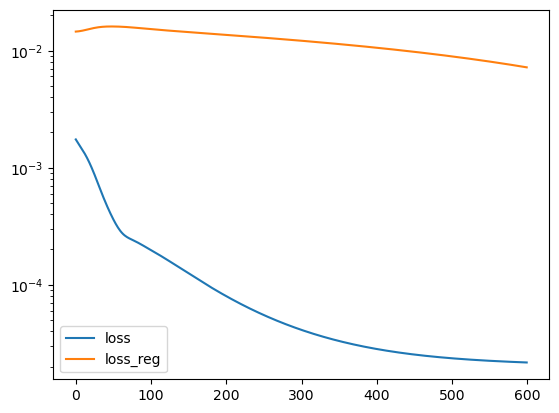

In [109]:
%load_ext autoreload
%autoreload 2
from exrep.train import train_local_representation

explainer_config = dict(
    output_dim=32,
    # this temperature is for inference only!
    temperature=0.4,
    use_key_encoder=False,
)
explainer_loss_config = dict(
    gamma1=1.0,
    gamma2=1.0,
    temp_student=0.4,
    temp_teacher=0.4,
)
explainer_optimizer_config = dict(
    lr=3e-3,
    weight_decay=1e-3,
)

explainer_shape, logs_exp_shape = train_local_representation(
    model_config=explainer_config,
    loss_config=explainer_loss_config,
    optimizer_config=explainer_optimizer_config,
    query_inputs=torch.tensor(numeric_features, dtype=torch.float32),
    query_targets=shape_embeddings,
    keys=shape_embeddings,
    groups=[(i, ) for i in range(numeric_features.shape[1])],
    alpha=0.001,
    num_epochs=600,
    batch_size=1024,
    log_every_n_steps=10,
    device=device,
)

for log in logs_exp_shape:
    log["loss_total"] = log["loss_reg"] + log["loss"]

plt.plot([log['loss'] for log in logs_exp_shape], label="loss")
plt.plot([log['loss_reg'] for log in logs_exp_shape], label="loss_reg")
plt.legend()
plt.yscale("log")
# plt.plot([log['loss'] for log in logs_exp_shape])

In [108]:
exp_shape_sim = explainer_shape(torch.tensor(numeric_features[indices], dtype=torch.float32, device=device), shape_embeddings[indices].to(device))
print("Similarity matrix for shape:")
print(exp_shape_sim.round(decimals=3))

Similarity matrix for shape:
tensor([[0.1540, 0.1330, 0.1540, 0.1340, 0.1530, 0.1360, 0.1370],
        [0.1390, 0.1510, 0.1390, 0.1510, 0.1400, 0.1510, 0.1300],
        [0.1790, 0.1100, 0.1810, 0.1130, 0.1770, 0.1190, 0.1220],
        [0.1390, 0.1510, 0.1390, 0.1510, 0.1400, 0.1510, 0.1300],
        [0.1670, 0.1210, 0.1670, 0.1230, 0.1700, 0.1260, 0.1270],
        [0.1230, 0.1810, 0.1230, 0.1820, 0.1240, 0.1820, 0.0850],
        [0.1530, 0.1130, 0.1550, 0.1130, 0.1510, 0.1140, 0.2010]],
       device='cuda:7', grad_fn=<RoundBackward1>)


In [106]:
explainer_shape.query_encoder.weight[:, :].norm(p=2, dim=0)

tensor([0.2802, 0.2401, 0.3610, 0.5084, 0.2614, 0.2118, 0.3005, 0.3195, 0.0057,
        0.4308, 0.3180, 0.4801, 0.3683, 0.2836, 0.3987, 0.1290, 0.2874, 0.1650,
        0.3310], device='cuda:7', grad_fn=<LinalgVectorNormBackward0>)

In [90]:
_, sorted_features = torch.sort(explainer_shape.query_encoder.weight[:, :].norm(p=2, dim=0))

In [93]:
a = np.zeros((19, 19))
for i, j in enumerate(sorted_features.tolist()):
    a[i, j] = 1
feature_encoder.inverse_transform(a)

array([['square_patch red'],
       ['square_rotated_patch red'],
       ['triangle_patch blue'],
       ['circle_patch blue'],
       ['square_patch blue'],
       ['square_patch green'],
       ['square_rotated_patch yellow'],
       ['square_patch black'],
       ['circle_patch red'],
       ['triangle_patch yellow'],
       ['square_rotated_patch blue'],
       ['circle_patch green'],
       ['triangle_patch green'],
       ['circle_patch yellow'],
       ['triangle_patch black'],
       ['square_rotated_patch green'],
       ['circle_patch black'],
       ['triangle_patch red'],
       ['square_rotated_patch black']], dtype=object)

2025-01-21 23:24:36 - INFO - Epoch  0, Step    0, Loss: 1.09190
2025-01-21 23:24:36 - INFO - Epoch  1, Step    0, Loss: 1.09184
2025-01-21 23:24:36 - INFO - Epoch  2, Step    0, Loss: 1.09178
2025-01-21 23:24:36 - INFO - Epoch  3, Step    0, Loss: 1.09173
2025-01-21 23:24:36 - INFO - Epoch  4, Step    0, Loss: 1.09168


2025-01-21 23:24:36 - INFO - Epoch  5, Step    0, Loss: 1.09162
2025-01-21 23:24:36 - INFO - Epoch  6, Step    0, Loss: 1.09157
2025-01-21 23:24:36 - INFO - Epoch  7, Step    0, Loss: 1.09153
2025-01-21 23:24:36 - INFO - Epoch  8, Step    0, Loss: 1.09148
2025-01-21 23:24:36 - INFO - Epoch  9, Step    0, Loss: 1.09143
2025-01-21 23:24:36 - INFO - Epoch 10, Step    0, Loss: 1.09138
2025-01-21 23:24:37 - INFO - Epoch 11, Step    0, Loss: 1.09132
2025-01-21 23:24:37 - INFO - Epoch 12, Step    0, Loss: 1.09127
2025-01-21 23:24:37 - INFO - Epoch 13, Step    0, Loss: 1.09122
2025-01-21 23:24:37 - INFO - Epoch 14, Step    0, Loss: 1.09117
2025-01-21 23:24:37 - INFO - Epoch 15, Step    0, Loss: 1.09111
2025-01-21 23:24:37 - INFO - Epoch 16, Step    0, Loss: 1.09105
2025-01-21 23:24:37 - INFO - Epoch 17, Step    0, Loss: 1.09100
2025-01-21 23:24:37 - INFO - Epoch 18, Step    0, Loss: 1.09094
2025-01-21 23:24:37 - INFO - Epoch 19, Step    0, Loss: 1.09088
2025-01-21 23:24:37 - INFO - Epoch 20, S

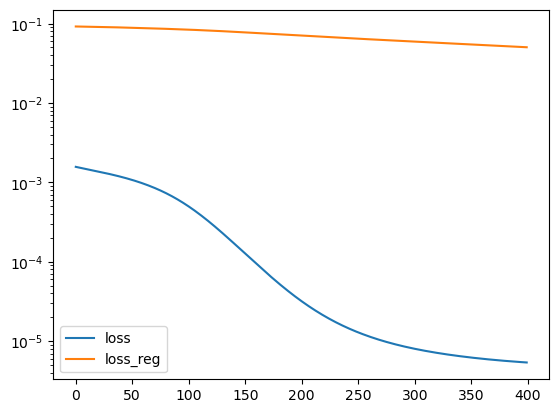

In [195]:
explainer_optimizer_config = dict(
    lr=1e-3,
    weight_decay=1e-2,
)

explainer_color, logs_exp_color = train_local_representation(
    model_config=explainer_config,
    loss_config=explainer_loss_config,
    optimizer_config=explainer_optimizer_config,
    query_inputs=torch.tensor(numeric_features, dtype=torch.float32),
    query_targets=color_embeddings,
    keys=color_embeddings,
    groups=[(i, ) for i in range(numeric_features.shape[1])],
    alpha=0.01,
    num_epochs=400,
    batch_size=1024,
    log_every_n_steps=10,
    device=device,
)

for log in logs_exp_color:
    log["loss_total"] = log["loss_reg"] + log["loss"]

plt.plot([log['loss'] for log in logs_exp_color], label="loss")
plt.plot([log['loss_reg'] for log in logs_exp_color], label="loss_reg")
plt.legend()
plt.yscale("log")
# plt.plot([log['loss'] for log in logs_exp_shape])

In [196]:
exp_color_sim = explainer_color(torch.tensor(numeric_features[indices], dtype=torch.float32, device=device), color_embeddings[indices].to(device))
print("Similarity matrix for color:")
print(exp_color_sim.round(decimals=3))
print("Reference similarity matrix for color:")
print(torch.softmax(reps_color @ reps_color.T / 0.4, dim=1).round(decimals=3))

Similarity matrix for color:
tensor([[0.6170, 0.0640, 0.0660, 0.0630, 0.0610, 0.0670, 0.0620],
        [0.0320, 0.2900, 0.0300, 0.2900, 0.2880, 0.0340, 0.0350],
        [0.0270, 0.0240, 0.4370, 0.0240, 0.0270, 0.4320, 0.0300],
        [0.0320, 0.2900, 0.0300, 0.2900, 0.2880, 0.0340, 0.0350],
        [0.0320, 0.2870, 0.0330, 0.2870, 0.2880, 0.0370, 0.0350],
        [0.0290, 0.0260, 0.4320, 0.0260, 0.0290, 0.4260, 0.0320],
        [0.0520, 0.0630, 0.0610, 0.0630, 0.0510, 0.0480, 0.6620]],
       device='cuda:7', grad_fn=<RoundBackward1>)
Reference similarity matrix for color:
tensor([[0.7940, 0.0350, 0.0350, 0.0340, 0.0320, 0.0360, 0.0330],
        [0.0140, 0.3170, 0.0120, 0.3170, 0.3090, 0.0140, 0.0170],
        [0.0200, 0.0180, 0.4550, 0.0170, 0.0200, 0.4450, 0.0230],
        [0.0140, 0.3170, 0.0120, 0.3170, 0.3090, 0.0140, 0.0170],
        [0.0130, 0.3110, 0.0140, 0.3120, 0.3190, 0.0170, 0.0130],
        [0.0210, 0.0210, 0.4430, 0.0210, 0.0250, 0.4530, 0.0170],
        [0.0320, 0.0430

In [197]:
explainer_color.query_encoder.weight[:, :].norm(p=2, dim=0)

tensor([0.0997, 0.1430, 0.1275, 0.1130, 0.9714, 0.9726, 0.8819, 0.8458, 0.8694],
       device='cuda:7', grad_fn=<LinalgVectorNormBackward0>)